### Pull funnel conversion rates by channel from google sheet

In [79]:
!pip install --upgrade gspread

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [80]:
import gspread
import pandas as pd
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [81]:
from google.cloud import bigquery
from google.colab import auth
#this authenicates you to access Google stuff from this notebook
#a new window will open - you gotta Allow access to Google for your Bestow account
#then you gotta copy/paste a code back in this notebook in the given box
auth.authenticate_user()

In [82]:
# import funnel conversation rates tab
sheet_id = '1JS825Rg1Cxs4uXiW4Fj3g93M39OEuxfnx7PwMaLU9MY'
sheet_name = 'Funnel Conversion Rates'

In [83]:
from google.auth import default

creds, _ = default()

gc = gspread.authorize(creds)
sh = gc.open_by_key(sheet_id)
worksheet = sh.worksheet(sheet_name)

In [88]:
data = worksheet.get_all_values()
rates = pd.DataFrame(data[1:], columns=data[0])

# Print the first few rows of the dataframe
print(rates.head())

                       channel open_rate submit_rate approve_rate bind_rate
0  Affiliates-Ad Practitioners    0.1695      0.7688       0.3233    0.3735
1             Affiliates-Other     0.123      0.8431       0.1988    0.2864
2       CLM-Customer Referrals    0.1567      0.9378       0.3977    0.8421
3            Direct Mail-Other    0.1795      1.2193       0.1903    0.2048
4                 Direct-Other    0.0312      0.7012       0.3061    0.3952


In [94]:
rates.iloc[:,1:] = rates.iloc[:,1:].astype(float)

WARNING - (py.warnings._showwarnmsg) - <ipython-input-94-dfe61e96fe05>:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rates.iloc[:,1:] = rates.iloc[:,1:].astype(float)

  rates.iloc[:,1:] = rates.iloc[:,1:].astype(float)



In [96]:
rates.dtypes

channel          object
open_rate       float64
submit_rate     float64
approve_rate    float64
bind_rate       float64
dtype: object

In [97]:
active_open = rates['channel'].unique().tolist()
active_open

['Affiliates-Ad Practitioners',
 'Affiliates-Other',
 'CLM-Customer Referrals',
 'Direct Mail-Other',
 'Direct-Other',
 'Display-Facebook',
 'Partners-Chime',
 'Partners-Credit Karma',
 'Partners-Experian',
 'Partners-Stash',
 'Partners-Stash Tile',
 'Search-Bing Branded',
 'Search-Google Branded',
 'Search-Google Non-Branded',
 'SEO-SEO']

In [98]:
active_open.remove('Partners-Stash')

### Pull funnel traffic by channel using Jessica's query

In [19]:
from google.cloud import bigquery
from google.colab import auth
#this authenicates you to access Google stuff from this notebook
#a new window will open - you gotta Allow access to Google for your Bestow account
#then you gotta copy/paste a code back in this notebook in the given box
auth.authenticate_user()

In [20]:
import pandas as pd

#assigning project
project_id = 'bstw-prod-warehouse'
#make the client
client = bigquery.Client(project=project_id)

In [47]:
query = '''
SELECT

EXTRACT(year FROM created_at_cst) AS yr
,EXTRACT(month FROM created_at_cst) AS month
,DATE(created_at_cst) AS dt
,COUNT(DISTINCT CASE WHEN status IN ('visit') THEN session_id
WHEN status IN ('open','submitted','approved') THEN application_id
WHEN status IN ('bound') THEN policy_id END) as users
,CASE WHEN acquisition_program_category_dm IN ('Direct Mail','Click Exchanges','Display','SEO'
,'Partners','Search','Content Providers','Affiliates') THEN acquisition_program_category_dm
WHEN acquisition_channel_dm = 'Customer Referrals' OR acquisition_channel_dm = 'Email' THEN 'CLM'
WHEN acquisition_channel_dm = 'Buzzery'or acquisition_channel_dm = 'Penny Hoarder' THEN 'Content Providers'
WHEN acquisition_source_dm in ( 'google_x','google_') THEN 'Search'
WHEN acquisition_channel_dm = 'Google Non-Branded' THEN 'Search'
ELSE 'Direct' END AS program
,CASE WHEN acquisition_channel_dm IN ('Valpak','Share Local','Applied Mind','Natural Intelligence','Assurance'
,'Media Alpha','Everquote','QuinStreet','Customer Referrals','Email','Penny Hoarder','Buzzery'
,'Credit Karma','Stash','Stash Tile','Chime','Varo','Credit Seasame','Experian','Google Non-Branded'
,'Bing Non-Branded','Bing Branded','Google Branded') THEN acquisition_channel_dm
WHEN acquisition_campaign_dm in ('pmax_google_nonbrand_prospecting_feb2023_tcpa','pmax_prospecting_feb2023_tcpa') THEN 'Google Non-Branded'
WHEN acquisition_source_dm in ('google_x') THEN 'Google Non-Branded'
WHEN acquisition_channel_dm IN ('Ad Practitioners','Consumers Advocate') THEN 'Ad Practitioners'
WHEN acquisition_channel_dm IN ('Facebook','Fb_Remarketing','Fb_Brand') THEN 'Facebook'
WHEN acquisition_channel_dm IN ('GDN','Yt_Brand','Discovery_Google','Youtube_Google') THEN 'GDN'
When acquisition_program_dm IN ('SEO') THEN 'SEO'
ELSE 'Other' END as channel
,status
,carrier_name
,device_type

FROM `bstw-prod-warehouse.mds_reporting.mdsr_funnel`

where business_line = 'direct'
and status in ('visit','open','submitted','approved','bound')
and created_at_cst  >= "2022-09-01" and  created_at_cst < date_trunc(current_date('America/Chicago'),day)



group by 1,2,3,5,6,7,8,9
'''

#this is the thing that runs the query and returns results in a pandas dataframe
df = pd.io.gbq.read_gbq(query, project_id=project_id, dialect='standard')

In [48]:
df.head()

yr  month          dt  users            program       channel status  \
0  2023      3  2023-03-10      1         Affiliates  Applied Mind  visit   
1  2022     10  2022-10-18      1           Partners          Varo  visit   
2  2022     11  2022-11-09      1    Click Exchanges     Assurance  visit   
3  2022      9  2022-09-06      4  Content Providers       Buzzery  visit   
4  2022     10  2022-10-14      1    Click Exchanges   Media Alpha  visit   

  carrier_name   device_type  
0         None  phone_iphone  
1         None         phone  
2         None       desktop  
3         None         phone  
4         None         phone

In [49]:
# filter out bot traffic and create program/channel combos
df = df[df['device_type'] != 'bot']
df['program_channel'] = df['program'].str.cat(df['channel'], sep='-')
df['program_channel'].unique()

array(['Affiliates-Applied Mind', 'Partners-Varo',
       'Click Exchanges-Assurance', 'Content Providers-Buzzery',
       'Click Exchanges-Media Alpha', 'Direct Mail-Share Local',
       'Display-GDN', 'Direct Mail-Valpak', 'Click Exchanges-Everquote',
       'Search-Bing Non-Branded', 'SEO-SEO', 'Partners-Chime',
       'CLM-Email', 'Direct-Other', 'Affiliates-Other',
       'Direct Mail-Other', 'Partners-Other', 'Search-Other',
       'Content Providers-Other', 'Display-Other',
       'Click Exchanges-Other', 'Partners-Stash', 'Partners-Experian',
       'Display-Facebook', 'Click Exchanges-QuinStreet',
       'Partners-Stash Tile', 'Search-Bing Branded',
       'Partners-Credit Karma', 'Content Providers-Penny Hoarder',
       'Search-Google Branded', 'Affiliates-Ad Practitioners',
       'CLM-Customer Referrals', 'Search-Google Non-Branded',
       'SEO-Google Non-Branded', 'Affiliates-Natural Intelligence'],
      dtype=object)

In [26]:
# create a dataframe of open apps, filtering to active channels
chan_open = df[(df['status'] == 'open') & (df['program_channel'].isin(active_open))].groupby(['yr', 'month', 'dt', 'program_channel','status']).sum('users').reset_index()
chan_open.head()

yr  month          dt              program_channel status  users
0  2022      9  2022-09-01  Affiliates-Ad Practitioners   open      2
1  2022      9  2022-09-01             Affiliates-Other   open      9
2  2022      9  2022-09-01       CLM-Customer Referrals   open      1
3  2022      9  2022-09-01            Direct Mail-Other   open      5
4  2022      9  2022-09-01                 Direct-Other   open     25

In [28]:
# convert the date to a datetime object
# data starts on 9-1-22
chan_open['dt'] = pd.to_datetime(chan_open['dt'])
chan_open['dt'].min()

Timestamp('2022-09-01 00:00:00')

In [29]:
# look at totals
chan_open.groupby('program_channel')['users'].sum().reset_index().sort_values('users', ascending = False)

program_channel  users
4                  Direct-Other   6572
7         Partners-Credit Karma   5535
10          Partners-Stash Tile   4638
8             Partners-Experian   3540
0   Affiliates-Ad Practitioners   2531
11                      SEO-SEO   2259
1              Affiliates-Other   1753
14    Search-Google Non-Branded   1429
13        Search-Google Branded   1304
6                Partners-Chime    988
5              Display-Facebook    952
9                Partners-Stash    740
3             Direct Mail-Other    292
2        CLM-Customer Referrals    189
12          Search-Bing Branded    169

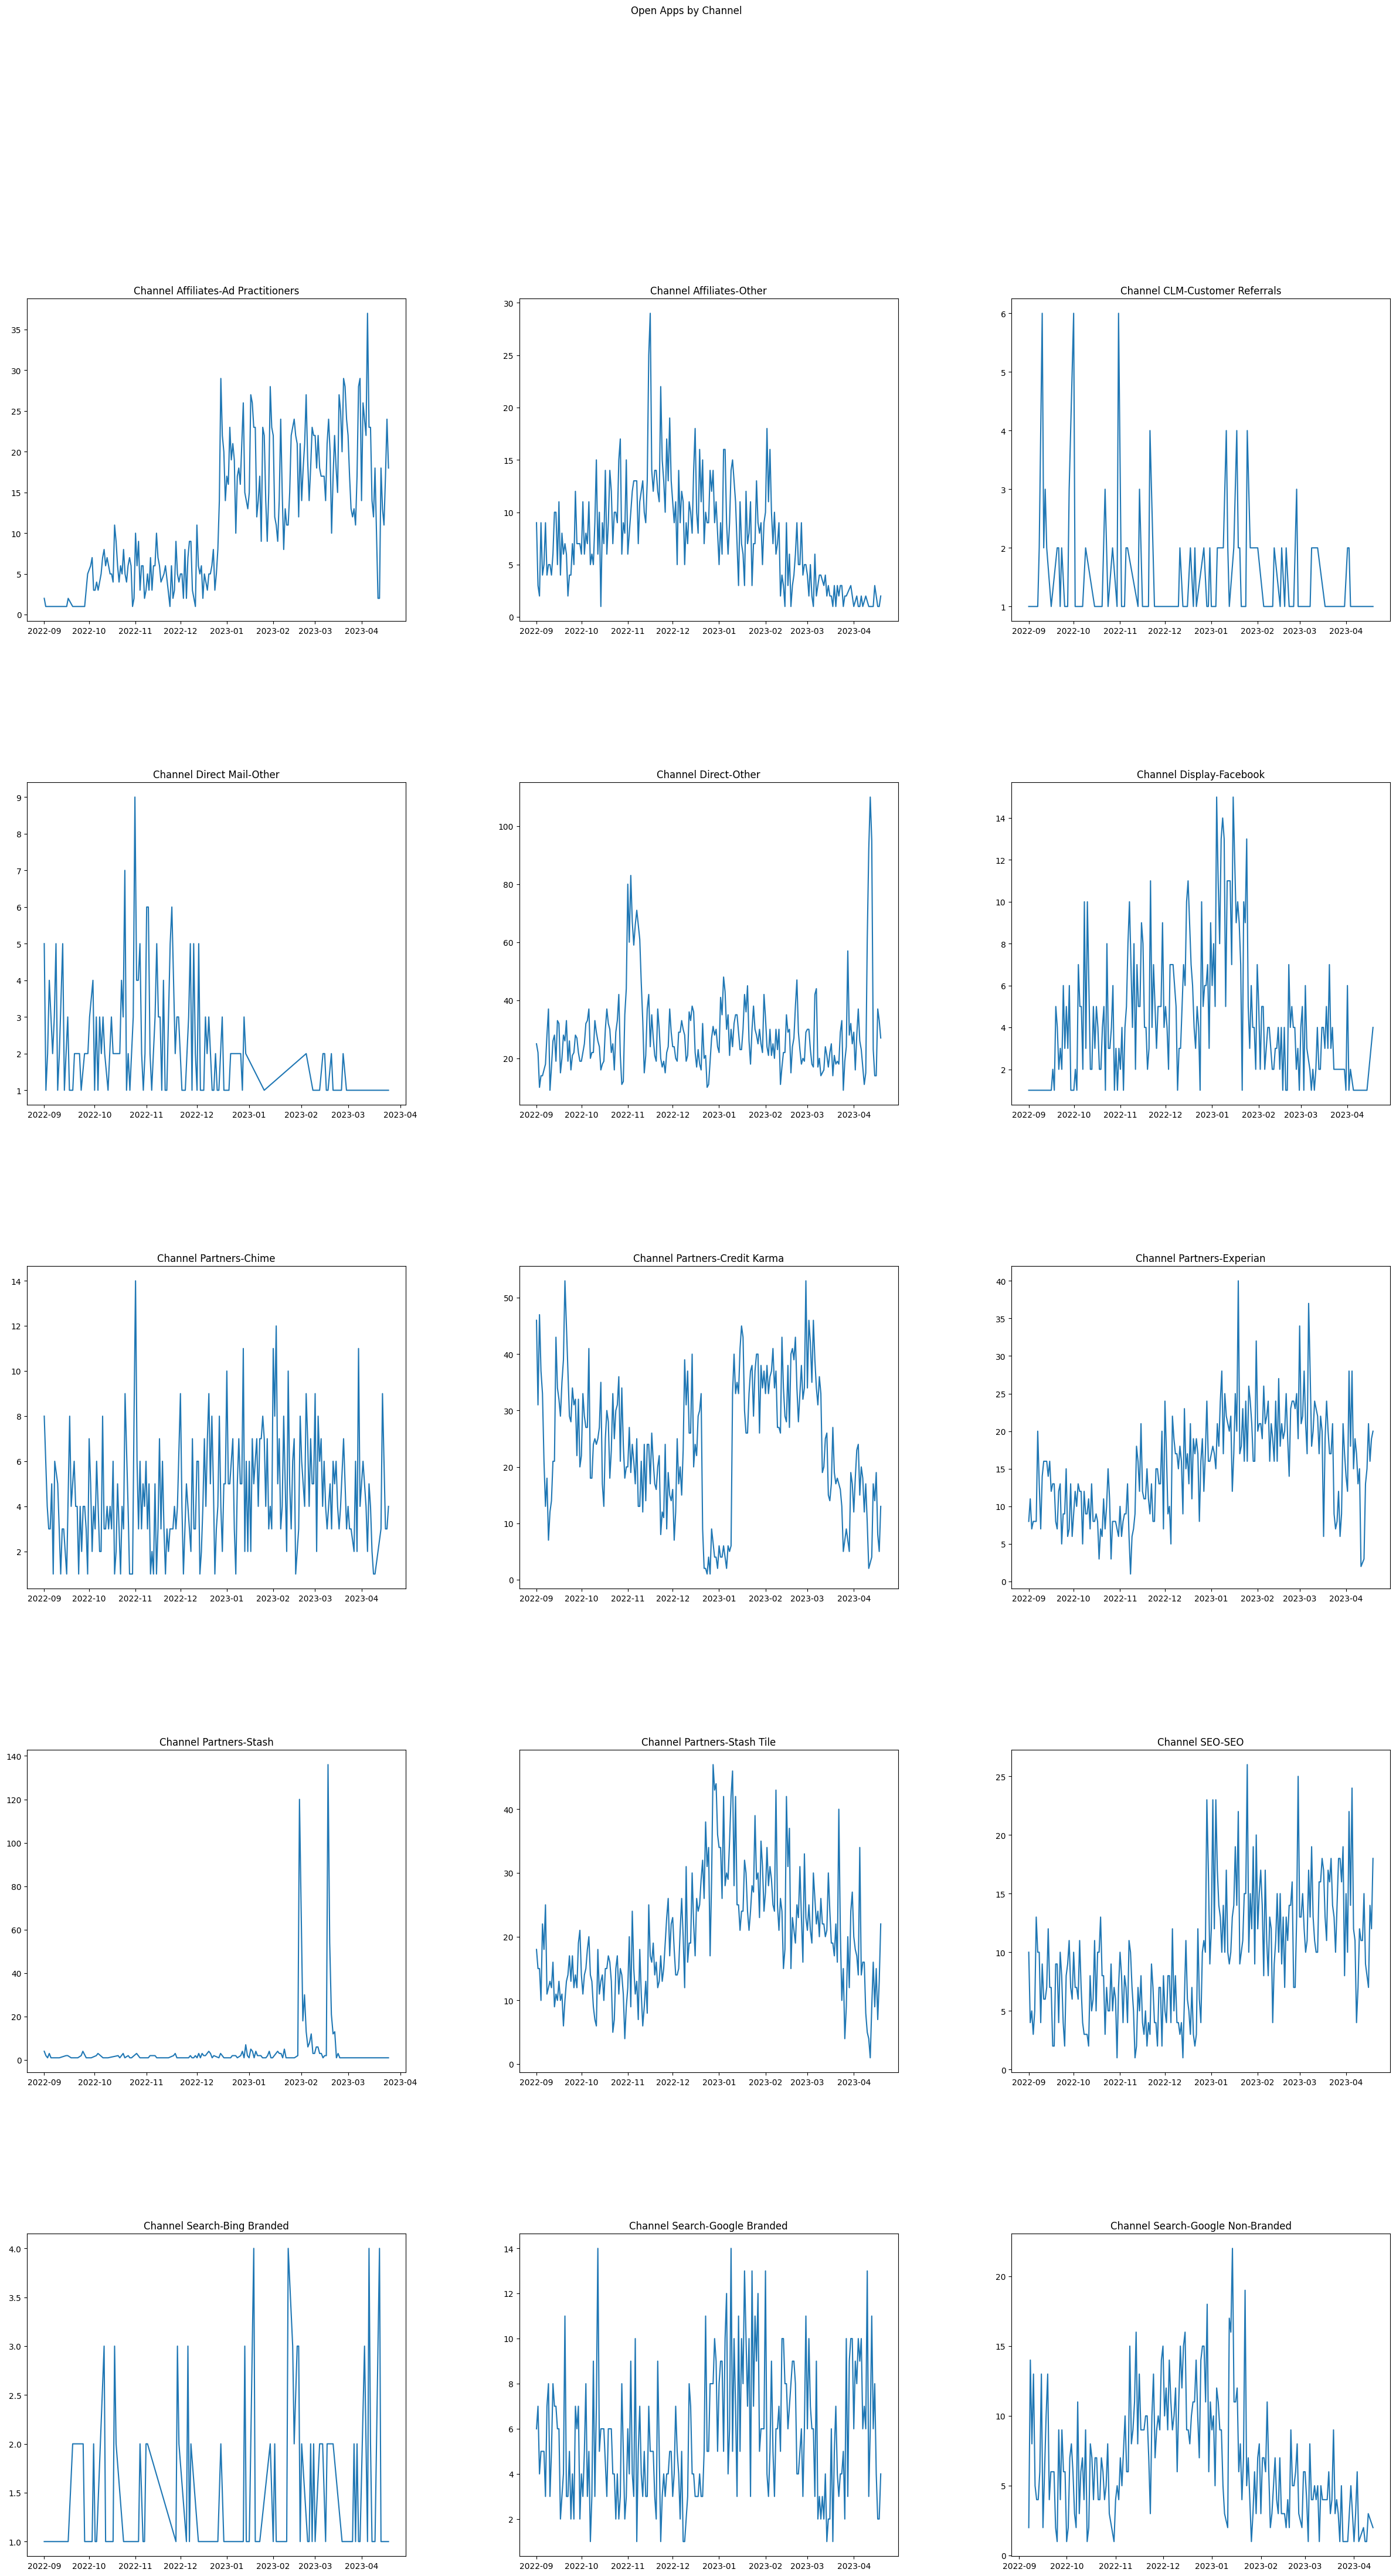

In [30]:
# plot trends by channel
import matplotlib.pyplot as plt
import numpy as np

# create a figure with 6 subplots
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(30, 50))

# iterate over the unique categories
for i, (cat, grp) in enumerate(chan_open.groupby('program_channel')):
    # determine the subplot indices
    row_idx = i // 3
    col_idx = i % 3
    # plot the data for this category
    axes[row_idx, col_idx].plot(grp['dt'], grp['users'])
    axes[row_idx, col_idx].set_title('Channel {}'.format(cat))

# add a title for the entire figure
fig.suptitle('Open Apps by Channel')

# adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.5)

# display the figure
plt.show()

In [33]:
pip install neuralprophet[live]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 4.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 56.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.4/887.4 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

## Predict Last 30 day Opens

In [35]:
# create start and end date for training set
# define test set as the last 30 days

from datetime import datetime
from pandas.core.arrays.timedeltas import timedelta

start_date = chan_open['dt'].min()
max_date = chan_open['dt'].max()
end_date = max_date - timedelta(days=30)

test = chan_open[(chan_open['dt'] >= end_date) & (chan_open['dt'] < max_date)].sort_values('dt').reset_index()
train = chan_open[((chan_open['dt'] >= start_date) & (chan_open['dt'] < end_date))].sort_values('dt').reset_index()

In [37]:
# this code runs through all the channels and generates a forecast for each one
# forecasts are stored in the test_forecasts list

test_forecasts = []

from neuralprophet import NeuralProphet

for i, channel in enumerate(active_open):

  print(i)
  print(channel)

  df = chan_open[chan_open['program_channel'] == channel]

  df_train = train[train['program_channel'] == channel][["dt", "users"]]
  df_train.rename(columns={"dt": "ds", "users": "y"}, inplace=True)
  df_train['y'] = df_train['y'].astype(float)

  df_test = test[test['program_channel'] == channel][["dt", "users"]]
  df_test.rename(columns={"dt": "ds", "users": "y"}, inplace=True)
  df_test['y'] = df_test['y'].astype(float)

  m = NeuralProphet(trend_reg = 0, seasonality_reg = 0, seasonality_mode='multiplicative')

  train_metrics = m.fit(df_train, 
                        freq="D")
  
  forecast = m.predict(df_test)
  test_forecasts.append(forecast)

/usr/local/lib/python3.9/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.9/dist-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator9allocatorE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.5% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.5% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normaliza

0
SEO-SEO


WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (13) is too small than the required number for the learning rate finder (211). The results might not be optimal.


Finding best initial lr:   0%|          | 0/211 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.667% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 96.667% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.667% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 96.667% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D


Predicting: 13it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.373% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 96.373% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO:NP.utils:Disabling yearly seasonality. Run NeuralProphet with yearly_season

1
Partners-Chime


WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (13) is too small than the required number for the learning rate finder (211). The results might not be optimal.


Finding best initial lr:   0%|          | 0/211 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 84.0% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 84.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 84.0% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 84.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D


Predicting: 13it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.5% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.5% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO:NP.utils:Disabling yearly seasonality. Run NeuralProphet with yearly_seasonalit

2
Direct-Other


WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (13) is too small than the required number for the learning rate finder (211). The results might not be optimal.


Finding best initial lr:   0%|          | 0/211 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.667% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 96.667% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.667% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 96.667% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D


Predicting: 13it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.485% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 98.485% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO:NP.utils:Disabling yearly seasonality. Run NeuralProphet with yearly_season

3
Affiliates-Other


WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (13) is too small than the required number for the learning rate finder (211). The results might not be optimal.


Finding best initial lr:   0%|          | 0/211 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 68.182% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 68.182% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq D. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 68.182% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 68.182% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq D. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.


Predicting: 13it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 82.4% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 82.4% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO:NP.utils:Disabling yearly seasonality. Run NeuralProphet with yearly_seasonalit

4
Direct Mail-Other


WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (8) is too small than the required number for the learning rate finder (208). The results might not be optimal.


Finding best initial lr:   0%|          | 0/208 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 66.667% of the data.
INFO:NP.df_utils:Major frequency B corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq D. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 66.667% of the data.
INFO:NP.df_utils:Major frequency B corresponds to 66.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq D. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.


Predicting: 8it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.995% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 98.995% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO:NP.utils:Disabling yearly seasonality. Run NeuralProphet with yearly_season

5
Partners-Experian


WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (13) is too small than the required number for the learning rate finder (211). The results might not be optimal.


Finding best initial lr:   0%|          | 0/211 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 93.103% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 93.103% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 93.103% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 93.103% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D


Predicting: 13it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.335% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 96.335% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO:NP.utils:Disabling yearly seasonality. Run NeuralProphet with yearly_season

6
Display-Facebook


WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (12) is too small than the required number for the learning rate finder (211). The results might not be optimal.


Finding best initial lr:   0%|          | 0/211 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 68.75% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 68.75% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq D. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 68.75% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 68.75% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq D. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.


Predicting: 12it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.5% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.5% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO:NP.utils:Disabling yearly seasonality. Run NeuralProphet with yearly_seasonalit

7
Partners-Stash Tile


WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (13) is too small than the required number for the learning rate finder (211). The results might not be optimal.


Finding best initial lr:   0%|          | 0/211 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.667% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 96.667% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.667% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 96.667% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D


Predicting: 13it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 53.261% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 53.261% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq D. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this

8
Search-Bing Branded


WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (6) is too small than the required number for the learning rate finder (207). The results might not be optimal.


Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 58.824% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 58.824% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq D. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 58.824% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 58.824% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq D. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.


Predicting: 6it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.995% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 98.995% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO:NP.utils:Disabling yearly seasonality. Run NeuralProphet with yearly_season

9
Partners-Credit Karma


WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (13) is too small than the required number for the learning rate finder (211). The results might not be optimal.


Finding best initial lr:   0%|          | 0/211 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 93.103% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 93.103% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 93.103% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 93.103% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D


Predicting: 13it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 97.97% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 97.97% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO:NP.utils:Disabling yearly seasonality. Run NeuralProphet with yearly_seasonal

10
Search-Google Branded


WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (13) is too small than the required number for the learning rate finder (211). The results might not be optimal.


Finding best initial lr:   0%|          | 0/211 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.667% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 96.667% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.667% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 96.667% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D


Predicting: 13it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 94.318% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 94.318% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO:NP.utils:Disabling yearly seasonality. Run NeuralProphet with yearly_season

11
Affiliates-Ad Practitioners


WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (11) is too small than the required number for the learning rate finder (211). The results might not be optimal.


Finding best initial lr:   0%|          | 0/211 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 93.103% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 93.103% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 93.103% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 93.103% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D


Predicting: 11it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 55.14% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 55.14% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq D. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.


12
CLM-Customer Referrals


WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (7) is too small than the required number for the learning rate finder (207). The results might not be optimal.


Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 41.667% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq D. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 41.667% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 41.667% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq D. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.


Predicting: 7it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.257% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 96.257% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.


13
Search-Google Non-Branded


INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO:NP.utils:Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:NP.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO:NP.config:Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 378
INFO:NP.config:Auto-set epochs to 378
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (12) is too small than the required number for the learning rate finder (211). The results might not be optimal.


Finding best initial lr:   0%|          | 0/211 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D


Predicting: 12it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


In [54]:
channels = []
visits = []
opens = []
submits = []
approved = []
bind = []

# run through each channel and pull funnel metrics from the data

for channel in active_open:
  df['dt'] = pd.to_datetime(df['dt'])
  # summarize opens, submits, approvals, and bounds by channel
  channel_data = df[(df['program_channel'] == channel) & (df['dt'] >= end_date) & (df['dt'] < max_date)]
  df2 = channel_data.groupby('status')['users'].sum().reset_index()
  # print(df2)

  try:
    visit = df2.loc[df2['status'] == 'visit', 'users'].iloc[0]
  except IndexError:
    visit = 0
  try:
    open = df2.loc[df2['status'] == 'open', 'users'].iloc[0]
  except IndexError:
    open = 0
  try:
    submitted = df2.loc[df2['status'] == 'submitted', 'users'].iloc[0]
  except IndexError:
    submitted = 0
  try:
    approve = df2.loc[df2['status'] == 'approved', 'users'].iloc[0]
  except IndexError:
    approve = 0
  try:
      bound = df2.loc[df2['status'] == 'bound', 'users'].iloc[0]
  except IndexError:
      bound = 0

  # append values to corresponding lists
  channels.append(channel)
  visits.append(visit)
  opens.append(open)
  submits.append(submitted)
  approved.append(approve)
  bind.append(bound)

# create a dictionary with the lists as values

data = {'channel': channels, 'visits_actual': visits, 'open_actual': opens, 'submit_actual': submits, 'approve_actual': approved, 'bound_actual': bind}

# create a Pandas DataFrame from the dictionary
df_actual = pd.DataFrame(data)

df_actual.head()

channel  visits_actual  open_actual  submit_actual  \
0            SEO-SEO           7620          399            284   
1     Partners-Chime            678          104             75   
2       Direct-Other          21487          992            597   
3   Affiliates-Other            618           39             32   
4  Direct Mail-Other             53            3              3   

   approve_actual  bound_actual  
0              79            25  
1               5             0  
2             127            46  
3               6             3  
4               0             0

In [64]:
# this function sums the predicted and actual started apps for each channel
def monthly_opens(channel,forecast):
  open_actual = round(forecast['y'].sum(),0)
  pred_open = round(forecast['yhat1'].sum(),0)
  # pct_error = round((pred - actual)/actual*100, 1)

  return open_actual, pred_open

In [65]:
# create empty lists for each variable
channels = []
actuals = []
preds = []


# iterate through active channels and test forecasts
for channel, forecast in zip(active_open, test_forecasts):
    # compute monthly visits for each channel and forecast
    actual, pred = monthly_opens(channel, forecast)
    
    # append values to corresponding lists
    channels.append(channel)
    actuals.append(actual)
    preds.append(pred)


# create a dictionary with the lists as values
data = {'channel': channels,  'pred_open': preds}

# create a Pandas DataFrame from the dictionary
df_open = pd.DataFrame(data)
# df_open.head()
df_open.shape

(14, 2)

In [73]:
# combine conversion rates with the predicted number of open apps
open_preds = pd.merge(rates, df_open, on= 'channel')
open_preds.head()

channel open_rate submit_rate approve_rate bind_rate  \
0  Affiliates-Ad Practitioners    0.1695      0.7688       0.3233    0.3735   
1             Affiliates-Other     0.123      0.8431       0.1988    0.2864   
2       CLM-Customer Referrals    0.1567      0.9378       0.3977    0.8421   
3            Direct Mail-Other    0.1795      1.2193       0.1903    0.2048   
4                 Direct-Other    0.0312      0.7012       0.3061    0.3952   

   pred_open  
0      602.0  
1        3.0  
2       11.0  
3        3.0  
4      582.0

In [75]:
# compute predcted visits, submits, approvals and binds from predicted opens and conversion rates
open_preds['pred_visit'] = open_preds.apply(lambda x: round(x.pred_open/x.open_rate,0), axis=1)
open_preds['pred_submit'] = open_preds.apply(lambda x: round(x.pred_open*x.submit_rate,0), axis=1)
open_preds['pred_approved'] = open_preds.apply(lambda x: round(x.pred_submit*x.approve_rate,0), axis=1)
open_preds['pred_bind'] = open_preds.apply(lambda x: round(x.pred_approved*x.bind_rate,0), axis=1)

open_preds.head()

channel  open_rate  submit_rate  approve_rate  \
0  Affiliates-Ad Practitioners     0.1695       0.7688        0.3233   
1             Affiliates-Other     0.1230       0.8431        0.1988   
2       CLM-Customer Referrals     0.1567       0.9378        0.3977   
3            Direct Mail-Other     0.1795       1.2193        0.1903   
4                 Direct-Other     0.0312       0.7012        0.3061   

   bind_rate  pred_open  pred_visit  pred_submit  pred_approved  pred_bind  
0     0.3735      602.0      3552.0        463.0          150.0       56.0  
1     0.2864        3.0        24.0          3.0            1.0        0.0  
2     0.8421       11.0        70.0         10.0            4.0        3.0  
3     0.2048        3.0        17.0          4.0            1.0        0.0  
4     0.3952      582.0     18654.0        408.0          125.0       49.0

In [76]:
# combine everything into a single dataframe
df_all = pd.merge(open_preds, df_actual, on = 'channel')
df_all

channel  open_rate  submit_rate  approve_rate  \
0   Affiliates-Ad Practitioners     0.1695       0.7688        0.3233   
1              Affiliates-Other     0.1230       0.8431        0.1988   
2        CLM-Customer Referrals     0.1567       0.9378        0.3977   
3             Direct Mail-Other     0.1795       1.2193        0.1903   
4                  Direct-Other     0.0312       0.7012        0.3061   
5              Display-Facebook     0.0937       0.6510        0.1878   
6                Partners-Chime     0.1902       0.7160        0.1239   
7         Partners-Credit Karma     0.1667       0.7070        0.2340   
8             Partners-Experian     0.1006       0.7308        0.1966   
9           Partners-Stash Tile     0.1016       0.6928        0.1673   
10          Search-Bing Branded     0.0643       0.8069        0.2366   
11        Search-Google Branded     0.0907       0.8311        0.3673   
12    Search-Google Non-Branded     0.0827       0.6921        0.2333   
13                      SEO-SEO     0.0516       0.8185        0.3439   

    bind_rate  pred_open  pred_visit  pred_submit  pred_approved  pred_bind  \
0      0.3735      602.0      3552.0        463.0          150.0       56.0   
1      0.2864        3.0        24.0          3.0            1.0        0.0   
2      0.8421       11.0        70.0         10.0            4.0        3.0   
3      0.2048        3.0        17.0          4.0            1.0        0.0   
4      0.3952      582.0     18654.0        408.0          125.0       49.0   
5      0.1610       13.0       139.0          8.0            2.0        0.0   
6      0.0791      109.0       573.0         78.0           10.0        1.0   
7      0.1803      721.0      4325.0        510.0          119.0       21.0   
8      0.1775      629.0      6252.0        460.0           90.0       16.0   
9      0.2062      588.0      5787.0        407.0           68.0       14.0   
10     0.3817       28.0       435.0         23.0            5.0        2.0   
11     0.3815       63.0       695.0         52.0           19.0        7.0   
12     0.2966       76.0       919.0         53.0           12.0        4.0   
13     0.4126      401.0      7771.0        328.0          113.0       47.0   

    visits_actual  open_actual  submit_actual  approve_actual  bound_actual  
0            4292          543            382             111            49  
1             618           39             32               6             3  
2              91           14             12               3             1  
3              53            3              3               0             0  
4           21487          992            597             127            46  
5             742           41             32               5             0  
6             678          104             75               5             0  
7            2599          388            279              53             7  
8            4773          432            308              34             9  
9            4519          456            290              41            11  
10            354           28             19               2             1  
11           1786          197            149              59            18  
12           1630           51             30              10             3  
13           7620          399            284              79            25

In [77]:
# create a function to get the percent error given the predicted and actual values
# apply to each of the funnel metrics by channel

def calculate_error(pred, actual):
    if actual == 0:
        return np.nan  # or you can return a specific value that indicates an error
    else:
        return round((pred - actual)/actual*100, 1)

df_all['visit_pct_error'] = df_all.apply(lambda x: calculate_error(x.pred_visit, x.visits_actual), axis=1)        
df_all['open_pct_error'] = df_all.apply(lambda x: calculate_error(x.pred_open, x.open_actual), axis=1)
df_all['submit_pct_error'] = df_all.apply(lambda x: calculate_error(x.pred_submit, x.submit_actual), axis=1)
df_all['approved_pct_error'] = df_all.apply(lambda x: calculate_error(x.pred_approved, x.approve_actual), axis=1)
df_all['bind_pct_error'] = df_all.apply(lambda x: calculate_error(x.pred_bind, x.bound_actual), axis=1)

df_all.head()

channel  open_rate  submit_rate  approve_rate  \
0  Affiliates-Ad Practitioners     0.1695       0.7688        0.3233   
1             Affiliates-Other     0.1230       0.8431        0.1988   
2       CLM-Customer Referrals     0.1567       0.9378        0.3977   
3            Direct Mail-Other     0.1795       1.2193        0.1903   
4                 Direct-Other     0.0312       0.7012        0.3061   

   bind_rate  pred_open  pred_visit  pred_submit  pred_approved  pred_bind  \
0     0.3735      602.0      3552.0        463.0          150.0       56.0   
1     0.2864        3.0        24.0          3.0            1.0        0.0   
2     0.8421       11.0        70.0         10.0            4.0        3.0   
3     0.2048        3.0        17.0          4.0            1.0        0.0   
4     0.3952      582.0     18654.0        408.0          125.0       49.0   

   visits_actual  open_actual  submit_actual  approve_actual  bound_actual  \
0           4292          543            382             111            49   
1            618           39             32               6             3   
2             91           14             12               3             1   
3             53            3              3               0             0   
4          21487          992            597             127            46   

   visit_pct_error  open_pct_error  submit_pct_error  approved_pct_error  \
0            -17.2            10.9              21.2                35.1   
1            -96.1           -92.3             -90.6               -83.3   
2            -23.1           -21.4             -16.7                33.3   
3            -67.9             0.0              33.3                 NaN   
4            -13.2           -41.3             -31.7                -1.6   

   bind_pct_error  
0            14.3  
1          -100.0  
2           200.0  
3             NaN  
4             6.5

In [ ]:
# save predictions to a csv in google drive
from google.colab import drive

drive.mount('/content/drive')
path = '/content/drive/My Drive/March_forecast.csv'

df_all.to_csv(path, index=False)

Mounted at /content/drive


In [ ]:
# aggregate forecast across all channels
sum = df_all[['visits_actual', 'pred_visit', 'pred_open', 'pred_submit',
       'pred_approved', 'pred_bind', 'open_actual', 'submit_actual',
       'approve_actual', 'bound_actual']].sum()

df_sum = pd.DataFrame(sum).transpose()

def calculate_error(pred, actual):
    if actual == 0:
        return np.nan  # or you can return a specific value that indicates an error
    else:
        return round((pred - actual)/actual*100, 1)

df_sum['visit_pct_error'] = df_sum.apply(lambda x: calculate_error(x.pred_visit, x.visits_actual), axis=1)        
df_sum['open_pct_error'] = df_sum.apply(lambda x: calculate_error(x.pred_open, x.open_actual), axis=1)
df_sum['submit_pct_error'] = df_sum.apply(lambda x: calculate_error(x.pred_submit, x.submit_actual), axis=1)
df_sum['approved_pct_error'] = df_sum.apply(lambda x: calculate_error(x.pred_approved, x.approve_actual), axis=1)
df_sum['bind_pct_error'] = df_sum.apply(lambda x: calculate_error(x.pred_bind, x.bound_actual), axis=1)

df_sum

visits_actual  pred_visit  pred_open  pred_submit  pred_approved  \
0        43582.0     43762.0     3639.0       2671.0          664.0   

   pred_bind  open_actual  submit_actual  approve_actual  bound_actual  \
0      193.0       3414.0         2411.0           549.0         172.0   

   visit_pct_error  open_pct_error  submit_pct_error  approved_pct_error  \
0              0.4             6.6              10.8                20.9   

   bind_pct_error  
0            12.2

## Use the model to make predictions for the next 30 days

In [ ]:
chan_open['dt'] = pd.to_datetime(chan_open['dt'])

max_date = chan_open['dt'].max()

# note that there will be no test set since we are making predictions for the future
# test = chan_open[(chan_open['dt'] >= '2023-03-01') & (chan_open['dt'] < '2023-03-24')].sort_values('dt').reset_index()
train = chan_open[((chan_open['dt'] >= start_date) & (chan_open['dt'] < end_date))].sort_values('dt').reset_index()

In [ ]:
# similar to above, generate forecasts by channel
# the difference is that we will not able to check accuracy since we have not data on the time period that we are predicting

future_forecasts = []

from neuralprophet import NeuralProphet

for i, channel in enumerate(active_open):

  print(i)
  print(channel)

  df = chan_open[chan_open['program_channel'] == channel]

  df_train = train[train['program_channel'] == channel][["dt", "users"]]
  df_train.rename(columns={"dt": "ds", "users": "y"}, inplace=True)
  df_train['y'] = df_train['y'].astype(float)

  # df_test = test[test['program_channel'] == channel][["dt", "users"]]
  # df_test.rename(columns={"dt": "ds", "users": "y"}, inplace=True)
  # df_test['y'] = df_test['y'].astype(float)

  m = NeuralProphet(trend_reg = 0, seasonality_reg = 0.01, seasonality_mode='multiplicative')

  train_metrics = m.fit(df_train, 
                        freq="D")
  
  future = m.make_future_dataframe(df_train, periods = 38, n_historic_predictions = len(df_train))
  forecast = m.predict(future)
  future_forecasts.append(forecast)

/usr/local/lib/python3.9/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.9/dist-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator9allocatorE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO:NP.config:Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.51% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.51% of the data.
INFO - (NP.df_utils._infer_frequ

0
SEO-SEO


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.9/dist-packages/lightning_fabric/accelerators/cuda.py:236: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")

  warnings.warn("Can't initialize NVML")

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")

  warnings.warn("Can't initialize NVML")

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (13) is too small than the required number for the learning rate finder (212). The results might not be optimal.


Finding best initial lr:   0%|          | 0/212 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.51% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.51% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.587% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.587% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.587% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.587% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is e

Predicting: 13it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO:NP.config:Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 95.408% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 95.408% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities)

1
Partners-Chime


WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (13) is too small than the required number for the learning rate finder (211). The results might not be optimal.


Finding best initial lr:   0%|          | 0/211 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 95.408% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 95.408% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.154% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 96.154% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.154% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 96.154% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: 13it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO:NP.config:Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.51% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.51% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) -

2
Direct-Other


Finding best initial lr:   0%|          | 0/212 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.51% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.51% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.587% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.587% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.587% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.587% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is e

Predicting: 13it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO:NP.config:Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.515% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 98.515% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities)

3
Affiliates-Other


WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (13) is too small than the required number for the learning rate finder (212). The results might not be optimal.


Finding best initial lr:   0%|          | 0/212 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.515% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 98.515% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.75% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 98.75% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.75% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 98.75% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equ

Predicting: 13it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO:NP.config:Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 81.89% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 81.89% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) -

4
Direct Mail-Other


WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (8) is too small than the required number for the learning rate finder (208). The results might not be optimal.


Finding best initial lr:   0%|          | 0/208 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 81.89% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 81.89% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 86.061% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 86.061% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 86.061% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 86.061% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is e

Predicting: 8it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO:NP.config:Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 74.436% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 74.436% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities)

5
Partners-Stash


WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (9) is too small than the required number for the learning rate finder (209). The results might not be optimal.


Finding best initial lr:   0%|          | 0/209 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 74.436% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 74.436% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 80.117% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 80.117% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 80.117% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 80.117% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: 9it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO:NP.config:Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.015% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.015% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities)

6
Partners-Experian


WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (13) is too small than the required number for the learning rate finder (212). The results might not be optimal.


Finding best initial lr:   0%|          | 0/212 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.015% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.015% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.17% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.17% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.17% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.17% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equ

Predicting: 13it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO:NP.config:Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.41% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 96.41% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) -

7
Display-Facebook


WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (13) is too small than the required number for the learning rate finder (211). The results might not be optimal.


Finding best initial lr:   0%|          | 0/211 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.41% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 96.41% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.996% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 96.996% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.996% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 96.996% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is e

Predicting: 13it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO:NP.config:Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.51% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.51% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) -

8
Partners-Stash Tile


WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (13) is too small than the required number for the learning rate finder (212). The results might not be optimal.


Finding best initial lr:   0%|          | 0/212 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.51% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.51% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.587% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.587% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.587% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.587% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is e

Predicting: 13it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO:NP.config:Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 53.261% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 53.261% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq D. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as 

9
Search-Bing Branded


WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (6) is too small than the required number for the learning rate finder (207). The results might not be optimal.


Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 53.261% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 53.261% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq D. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 66.923% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 66.923% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq D. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency D cor

Predicting: 6it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO:NP.config:Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.015% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.015% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities)

10
Partners-Credit Karma


WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (13) is too small than the required number for the learning rate finder (212). The results might not be optimal.


Finding best initial lr:   0%|          | 0/212 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.015% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.015% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.17% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.17% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.17% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.17% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equ

Predicting: 13it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO:NP.config:Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.01% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 98.01% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) -

11
Search-Google Branded


WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (13) is too small than the required number for the learning rate finder (211). The results might not be optimal.


Finding best initial lr:   0%|          | 0/211 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.01% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 98.01% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.326% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 98.326% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.326% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 98.326% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is e

Predicting: 13it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO:NP.config:Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 94.444% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 94.444% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities)

12
Affiliates-Ad Practitioners


WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (12) is too small than the required number for the learning rate finder (211). The results might not be optimal.


Finding best initial lr:   0%|          | 0/211 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 94.444% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 94.444% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 95.413% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 95.413% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 95.413% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 95.413% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: 12it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO:NP.config:Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 55.556% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 55.556% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq D. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as 

13
CLM-Customer Referrals


WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (7) is too small than the required number for the learning rate finder (207). The results might not be optimal.


Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 55.556% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 55.556% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq D. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 67.123% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 67.123% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq D. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency D cor

Predicting: 7it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO:NP.config:Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.335% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 96.335% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities)

14
Search-Google Non-Branded


WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (12) is too small than the required number for the learning rate finder (211). The results might not be optimal.


Finding best initial lr:   0%|          | 0/211 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.335% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 96.335% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.943% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 96.943% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.943% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 96.943% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: 12it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


In [ ]:
# create empty lists for each variable
channels = []
preds = []


# iterate through active channels and compile 30 day forecast
for channel, forecast in zip(active_open, future_forecasts):
    # compute monthly visits for each channel and forecast
    next30 = forecast.tail(30)
    actual, pred = monthly_opens(channel, next30)
    
    # append values to corresponding lists
    channels.append(channel)
    preds.append(pred)


# create a dictionary with the lists as values
data = {'channel': channels,  'pred_open': preds}

# create a Pandas DataFrame from the dictionary
df_open_next30 = pd.DataFrame(data)
df_open_next30
# df_open_april.shape

channel  pred_open
0                       SEO-SEO      415.0
1                Partners-Chime      111.0
2                  Direct-Other      490.0
3              Affiliates-Other      -52.0
4             Direct Mail-Other       19.0
5                Partners-Stash      171.0
6             Partners-Experian      613.0
7              Display-Facebook       43.0
8           Partners-Stash Tile      561.0
9           Search-Bing Branded       51.0
10        Partners-Credit Karma      525.0
11        Search-Google Branded       38.0
12  Affiliates-Ad Practitioners      717.0
13       CLM-Customer Referrals       24.0
14    Search-Google Non-Branded       94.0

In [78]:
# create a function that adjusts funnel conversion rates based on various scenarios
scenario_1 = {'open_rate': 0, 'submit_rate': 0, 'approve_rate': .02, 'bind_rate': -.02}
scenario_2 = {'open_rate': 0, 'submit_rate': 0, 'approve_rate': .02, 'bind_rate': 0}
scenario_3 = {'open_rate': 0, 'submit_rate': 0, 'approve_rate': .02, 'bind_rate': .02}
scenario_4 = {'open_rate': 0, 'submit_rate': 0, 'approve_rate': .04, 'bind_rate': -.02}
scenario_5 = {'open_rate': 0, 'submit_rate': 0, 'approve_rate': .04, 'bind_rate': 0}
scenario_6 = {'open_rate': 0, 'submit_rate': 0, 'approve_rate': .04, 'bind_rate': .02}
scenario_7 = {'open_rate': 0, 'submit_rate': 0, 'approve_rate': .06, 'bind_rate': -.02}
scenario_8 = {'open_rate': 0, 'submit_rate': 0, 'approve_rate': .06, 'bind_rate': 0}
scenario_9 = {'open_rate': 0, 'submit_rate': 0, 'approve_rate': .06, 'bind_rate': .02}


# Add the values using the add() method of the DataFrame
scenarios = [scenario_1, scenario_2, scenario_3, scenario_4, scenario_5, scenario_6, scenario_7, scenario_8, scenario_9]

# Define a list of columns to add the values to
columns_to_add = ['open_rate', 'submit_rate', 'approve_rate', 'bind_rate']

results_dfs = []
for scenario in scenarios:
  df_1 = rates[columns_to_add].add(scenario, axis='columns')
  result_df = pd.concat([rates.drop(columns_to_add, axis=1), df_1], axis=1)
  results_dfs.append(result_df)



TypeError: ignored

In [ ]:
next30_dfs = []

for result_df in results_dfs:
  df_next30 = pd.merge(result_df, df_open_next30, on= 'channel')
  next30_dfs.append(df_next30)

                        channel  open_rate  submit_rate  approve_rate  \
0                       SEO-SEO     0.0516       0.8185        0.3639   
1                Partners-Chime     0.1902       0.7160        0.1439   
2                  Direct-Other     0.0312       0.7012        0.3261   
3              Affiliates-Other     0.1230       0.8431        0.2188   
4             Direct Mail-Other     0.1795       1.2193        0.2103   
5                Partners-Stash     0.1061       0.7608        0.1578   
6             Partners-Experian     0.1006       0.7308        0.2166   
7              Display-Facebook     0.0937       0.6510        0.2078   
8           Partners-Stash Tile     0.1016       0.6928        0.1873   
9           Search-Bing Branded     0.0643       0.8069        0.2566   
10        Partners-Credit Karma     0.1667       0.7070        0.2540   
11        Search-Google Branded     0.0907       0.8311        0.3873   
12  Affiliates-Ad Practitioners     0.1695       0.

In [ ]:
final_dfs =[]
for next30 in next30_dfs:
  next30['pred_visit'] = next30.apply(lambda x: round(x.pred_open/x.open_rate,0), axis=1)
  next30['pred_submit'] = next30.apply(lambda x: round(x.pred_open*x.submit_rate,0), axis=1)
  next30['pred_approved'] = next30.apply(lambda x: round(x.pred_submit*x.approve_rate,0), axis=1)
  next30['pred_bind'] = next30.apply(lambda x: round(x.pred_approved*x.bind_rate,0), axis=1)
  print(next30)
  final_dfs.append(next30)



                        channel  open_rate  submit_rate  approve_rate  \
0                       SEO-SEO     0.0516       0.8185        0.3639   
1                Partners-Chime     0.1902       0.7160        0.1439   
2                  Direct-Other     0.0312       0.7012        0.3261   
3              Affiliates-Other     0.1230       0.8431        0.2188   
4             Direct Mail-Other     0.1795       1.2193        0.2103   
5                Partners-Stash     0.1061       0.7608        0.1578   
6             Partners-Experian     0.1006       0.7308        0.2166   
7              Display-Facebook     0.0937       0.6510        0.2078   
8           Partners-Stash Tile     0.1016       0.6928        0.1873   
9           Search-Bing Branded     0.0643       0.8069        0.2566   
10        Partners-Credit Karma     0.1667       0.7070        0.2540   
11        Search-Google Branded     0.0907       0.8311        0.3873   
12  Affiliates-Ad Practitioners     0.1695       0.

In [ ]:
# save forecasts to google drive

from google.colab import drive

drive.mount('/content/drive')

for i, df in enumerate(final_dfs):
  file_name = f"April_forecast_{i}.csv"
  path = f"/content/drive/My Drive/{file_name}"
  df.to_csv(path, index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
